In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import unidecode
%matplotlib inline
import copy
from time import time

In [2]:
from gensim import corpora,models,similarities
from sklearn.cross_validation import KFold
from collections import defaultdict
from time import time
from itertools import product

In [3]:
from gensim import corpora,models,similarities
from gensim.utils import lemmatize
from string import punctuation
from spacy.parts_of_speech import ADV, NOUN, ADJ, PUNCT, VERB
from spacy.en import English,STOPWORDS
from spacy.orth import *
from HTMLParser import HTMLParser

## 1. Load the test set 

### 1.1 Load the ratings 

Two talks in the test set are musical performance and have no captions. They are detected later on when the captions are extracted. their talk ids are 179 and 1677, row indices are 32 and 257. They are removed here from both test.json and captions file in the following session. Similar situation is handled in Ted_9 for the training set.

In [4]:
test = pd.read_json('test2.json')

In [5]:
test.shape

(350, 33)

In [6]:
test.sort_values(by = 'id',inplace = True)

In [7]:
test.reset_index(drop = True,inplace = True)

In [8]:
test.ix[257,'id']

1677

In [9]:
test.drop([32,257],inplace = True)

In [10]:
test.reset_index(drop = True,inplace = True)

In [11]:
test.to_json('test3.json')

In [11]:
test_talkids = test['id']

In [12]:
iddict_test = dict([(item[1],item[0]) for item in test_talkids.iteritems()])

In [13]:
rowdict_test = dict([(item[0],item[1]) for item in test_talkids.iteritems()])

In [14]:
testratings = test.ix[:,:14]
ratingwords = list(testratings.columns)

In [15]:
testratings = testratings.fillna(0)

In [16]:
test_ratingsum_raw = testratings.sum(axis = 1)

In [17]:
testratings[ratingwords] = testratings[ratingwords]+1
testratings = testratings[ratingwords].div(test_ratingsum_raw+14,axis = 'index')

In [18]:
testratings['id'] = test['id']
testratings['gender'] = test['speaker_gender']

### Load the training ratings 

In [19]:
train = pd.read_json('train3.json')

In [20]:
train.sort_values(by = 'id',inplace = True)

In [21]:
train.reset_index(drop = True, inplace = True)

In [22]:
ids = train['id']

In [23]:
trainset = list(ids)

In [24]:
trainset = np.array(trainset)

In [25]:
iddict_train = dict([(item[1],item[0]) for item in ids.iteritems()])

In [26]:
rowdict_train = dict([(item[0],item[1]) for item in ids.iteritems()])

In [27]:
ratings = train.ix[:,:14]

In [28]:
ratings = ratings.fillna(0)

In [29]:
ratingsum_raw = ratings.sum(axis = 1)

##### laplace smoothing

In [30]:
ratings[ratingwords] = ratings[ratingwords]+1
ratings = ratings[ratingwords].div(ratingsum_raw+14,axis = 'index')

In [31]:
ratings['id'] = train['id']

In [32]:
ratings['gender'] = train['speaker_gender']

In [33]:
female_mean = ratings.groupby('gender')[ratingwords].mean().ix[0,:]
male_mean = ratings.groupby('gender')[ratingwords].mean().ix[1,:]

### 1.2 Load the test set captions 

In [36]:
cap_test = pd.read_json('captions_test_f.json')

In [37]:
cap_test.sort_values(by='id',inplace=True)

In [38]:
cap_test.reset_index(inplace = True,drop=True)

In [39]:
cap_test.drop([32,257],inplace = True)

In [40]:
cap_test.reset_index(inplace = True,drop = True)

In [43]:
cap_test.to_json('captions_test_f3.json')

## 2. Tokenize and vectorize the caption 

### 2.1 tokenization 

In [41]:
nlp = English()

In [42]:
def tokenize(text,islist = True):
    """
    This converts text to tokens, keeps only tokens 
    that are identified using coarse pos: noun and verb
    in: text -- default to be list of lines of transcript
        can also be a string
    www.ling.uppen.edu/courses/Fall_2003/ling001/penn_treebank_pos
    out:
        list of tokens
    """
    if islist:
        text = ' '.join(text)
    # remove '(Laughter)' etc, 
    text = re.sub('\([\w\s]+\)','',text)
    doc = nlp(text, parse = False)
    words = []
    for token in doc:
        # remove all tokens other than verbs and nouns
        if token.pos == NOUN or token.pos == VERB:
        # if token.tag_ in selected_tags:
            words.append(token)
    return words

In [43]:
tokens = cap_test.text.apply(tokenize)

In [44]:
def get_lemma(token_list):
    # remove stopwords
    lemmalist = []
    for token in token_list:
        if token.lemma_ not in STOPWORDS and len(token.lemma_) > 1:
            lemmalist.append(token.lemma_)
    return lemmalist

In [45]:
tokens_final = tokens.apply(get_lemma)

### including bigrams 

In [46]:
bigram = models.Phrases.load('./data/bigram')

In [47]:
token_phrase_final = list(tokens_final.apply(lambda x:bigram[x]))

### 2.2 Vectorize using the dictionary generated from the training set 

In [48]:
dictionary = corpora.Dictionary.load('./data/tedtrain.dict')

In [49]:
corpustest = [dictionary.doc2bow(text) for text in token_phrase_final]

#### save the test set corpus 

In [50]:
corpora.MmCorpus.serialize('./data/tedtest.mm',corpustest)

#### Tf-idf conversion 

In [51]:
tfidf = models.TfidfModel.load('./data/tfidf.model')

In [52]:
corpustest_idf = tfidf[corpustest]

In [53]:
corpora.MmCorpus.serialize('./data/corpustest_idf.mm',corpustest_idf)

### LSI conversion: using 40 topics as optimized using the training set

In [54]:
lsi = models.LsiModel.load('./data/lsi_40.model')

In [55]:
corpustest_lsi = lsi[corpustest_idf]

In [56]:
corpora.MmCorpus.serialize('./data/corpustest_lsi.mm',corpustest_lsi)

### Load the corpustrain_lsi_40 for similarity index 

In [57]:
corpustrain_lsi = corpora.MmCorpus('./data/corpustrain_lsi_40.mm')

In [58]:
index = similarities.MatrixSimilarity(corpustrain_lsi)

In [65]:
def give_similar_talks(talkid,corpus,index,trainset,num_of_talks = 10):
    """
    inputs: talkid,num_of_talks
            trainset: a series of ids
            index: the training set similarity matrix
            corpus: test set corpus
    outputs:
            a list of tuples, (talkid, cosine similarity score in descending order)
    """
    tmpset = set(trainset).difference(set([talkid])) # remove the target talk itself if it presents
    sims = index[corpus[iddict_test[talkid]]]
    sims = sorted(enumerate(sims),reverse = True, key = lambda x:x[1])
    res = []
    ctr = 0
    for key,value in sims:
        if rowdict_train[key] in tmpset:
            res.append((rowdict_train[key],value))
            ctr += 1
        if ctr >= num_of_talks:
            break
    return res

In [66]:
simsids = give_similar_talks(11,corpustest_lsi,index,ids,10)

In [67]:
simsids

[(340, 0.89024353),
 (69, 0.84226549),
 (76, 0.81959826),
 (1683, 0.80680287),
 (915, 0.78198254),
 (948, 0.77621514),
 (299, 0.77241135),
 (1816, 0.77056646),
 (728, 0.75199014),
 (409, 0.75061738)]

## 3. Tokenize and vectorize speaker background info for the test set 

In [68]:
speakers = pd.read_json('speakers.json')

In [69]:
speakers.sort_values(by = 'id',inplace = True)
speakers.set_index('id',inplace = True)

In [70]:
# initialize parser as an object
parser = HTMLParser()

In [71]:
# define a function to get speakers text info given speakers ids
def speakerinfo(ids):
    # ids is a list of ids, could be multiple speakers
    background = ''
    for speakerid in ids:
        text = ' '.join([speakers.ix[speakerid,'whylisten'], speakers.ix[speakerid,'whotheyare'], 
                speakers.ix[speakerid,'description']])
        text = parser.unescape(text)
        background += text
    return background

In [72]:
background = test['speaker_ids'].apply(speakerinfo)

In [73]:
speaker_background = pd.DataFrame({'talk_id':test['id'],'background':background})

### 3.1 tokenization 

In [74]:
sp_tokens = background.apply(tokenize,islist = False)

In [75]:
sp_tokens_final = sp_tokens.apply(get_lemma)

In [76]:
sp_bigram = models.Phrases.load('./data/spbigram')

In [77]:
sp_phrase_final = list(sp_tokens_final.apply(lambda x:sp_bigram[x]))

### 3.2 vectorization

In [78]:
sp_dictionary = corpora.Dictionary.load('./data/sp_train.dict')

In [79]:
print(sp_dictionary)

Dictionary(3517 unique tokens: [u'similarity', u'consumer_product', u'dynamic', u'penchant', u'protest']...)


#### bag of words corpus 

In [80]:
sp_corpustest = [sp_dictionary.doc2bow(text) for text in sp_phrase_final]

### 3.3 Tf-idf and LSI 

In [81]:
sp_tfidf = models.TfidfModel.load('./data/sp_tfidf.model')

#### Load the default sp_lsi (50 topics) as it was chosen by the cross validation on the training set 

In [83]:
sp_lsi = models.LsiModel.load('./data/sp_lsi.model')

In [88]:
sp_corpustrain_lsi = corpora.MmCorpus('./data/sp_corpustrain_lsi.mm')

In [84]:
sp_corpustest_idf = sp_tfidf[sp_corpustest]

In [85]:
sp_corpustest_lsi = sp_lsi[sp_corpustest_idf]

In [86]:
corpora.MmCorpus.serialize('./data/sp_corpustest_lsi.mm',sp_corpustest_lsi)

In [87]:
corpora.MmCorpus.serialize('./data/sp_corpustest_idf.mm',sp_corpustest_idf)

In [89]:
sp_index = similarities.MatrixSimilarity(sp_corpustrain_lsi)

In [90]:
sp_simlist = give_similar_talks(11,sp_corpustest_lsi,sp_index,ids,10)

In [91]:
sp_simlist

[(340, 1.0),
 (168, 0.73545212),
 (728, 0.67806983),
 (1777, 0.65473998),
 (2151, 0.64717019),
 (76, 0.62992835),
 (2141, 0.62835932),
 (879, 0.62688196),
 (773, 0.62591404),
 (1485, 0.62073839)]

## 4. Rating prediction
1. useful data from above: sp_index, index, sp_corpustest_lsi, corpustest_lsi,iddict_test(train), rowdict_test(train)
2. from notebook 10: steps for prediction of the test set:
    (1) use give_similar_talks to return similar talks based on transcripts and speaker backgrounds
    (2) merge the two lists into one
    (3) make prediction based on the list found in (2)

In [101]:
def give_similarities(talkid, corpus,index,similar_talks):
    """
    inputs:
            similar_talks: the list of talk ids that are from the other topic modeling results (e.g., similar
    speaker), but not contained in the current topic modeling (similar topics) results of most similar talks
            corpus: test set corpus
            index: training set similarity matrix
    
    outputs:
    return a list of tuples, (talkid, cosine similarity score), the list is not sorted on similarity score
    """
    tmpset = set(trainset)
    tmpset.discard(talkid) # remove the target talk itself if it presents
    sims = index[corpus[iddict_test[talkid]]]
    # sims = sorted(enumerate(sims),reverse = True, key = lambda x:x[1])
    # sims_id = [(rowdict[key],value) for key,value in sims]
    sim_dict = dict([(rowdict_train[ind],value) for ind,value in enumerate(sims)])
    res = [(tid,sim_dict[tid]) for tid in similar_talks]
    return res

In [95]:
def combine_similar_talks(talkid,num_trans,num_sp,trainset,corpus,index,sp_corpus,sp_index):
    """
    inputs: num_trans -- num of similar talks based on transcripts
            num_sp -- num of similar talks based on speaker background info
            trainset -- may not be the complete training set, e.g., in CV
            corpus -- test set corpus
            index -- train set index
    outputs:
            sim_talks -- the same output as give_similar_talks, a list of tuples (talkid, final_sim_score)
    """
    #1. find sim talks based on trans and sp
    sim_talks_trans = give_similar_talks(talkid,corpus,index,trainset,
                                         num_of_talks=num_trans)
    sim_talks_sp = give_similar_talks(talkid,sp_corpus,sp_index,trainset,
                                      num_of_talks=num_sp)
    #2. generate a combined list of similar talks

    # (1). determine the relationship of the two lists(sets), find the extra similarities, and append to the lists
    trans_set = set([x for x,y in sim_talks_trans])
    sp_set = set([x for x,y in sim_talks_sp])
    if sp_set.issubset(trans_set):
        # speaker set is a subset of trans_set, then find the speaker similarities for the talks that are in the
        # trans set but not in the speaker set
        extra_sim_talks_sp = give_similarities(talkid,sp_corpus,sp_index,
                                               list(trans_set.difference(sp_set)))
        # merge the extra into the original sim_talks_sp list
        sim_talks_sp.extend(extra_sim_talks_sp)
    elif sp_set.issuperset(trans_set):
        extra_sim_talks_trans = give_similarities(talkid,corpus,index,
                                                 list(sp_set.difference(trans_set)))
        sim_talks_trans.extend(extra_sim_talks_trans)
    else:
        sp_extra = list(sp_set.difference(trans_set))
        trans_extra = list(trans_set.difference(sp_set))
        # find both
        extra_sim_talks_trans = give_similarities(talkid,corpus,index,sp_extra)
        extra_sim_talks_sp = give_similarities(talkid,sp_corpus,sp_index,trans_extra)
        # extend to the original lists
        sim_talks_sp.extend(extra_sim_talks_sp)
        sim_talks_trans.extend(extra_sim_talks_trans)
    # 2. weight the two similarities to generate the final similarity score
    ## convert the two lists into dictionaries
    dict_talks_sp = dict(sim_talks_sp)
    dict_talks_trans = dict(sim_talks_trans)
    sim_talks = []
    for key in dict_talks_sp:
        # other weighting functions are not implemented yet!
        sim_talks.append((key,(dict_talks_sp[key]+dict_talks_trans[key])/2.))

    sim_talks.sort(reverse = True,key = lambda x:x[1])
    return sim_talks

In [108]:
def pred_rating2(talkid,trainset,num_trans,num_sp,corpus,index,sp_corpus,sp_index):
    """
    given the target talkid, the trainset and the two k values
    return the prediction as a numpy array
    input: trainset: a numpy array of training set talk ids 
           num_trans: k for transcript similarity
           num_sp: k for speaker background similarity
           corpus,index
           sp_corpus,sp_index
    output: a numpy array of predicted rating
    """
    sim_talks = combine_similar_talks(talkid,num_trans,num_sp,trainset,corpus,index,sp_corpus,sp_index)
    weights_sum = sum([sim for num,sim in sim_talks])
    # initialize rating_vect with zeros
    rating_vect = pd.Series(0,index = female_mean.index)
    for sim_talk_id,sim in sim_talks:
        sim_vect = ratings.ix[iddict_train[sim_talk_id],ratingwords]
        if train.ix[iddict_train[sim_talk_id],'speaker_gender'] == 0:
             sim_vect -= female_mean
        else:
             sim_vect -= male_mean
        rating_vect += sim_vect*sim
    if len(sim_talks) > 0:
        rating_vect /= weights_sum
    else:
        pass
        # print 'no similar talks is found for talk with id {}, base prediction is used'.format(talkid)
    # gender
    gender = test.ix[iddict_test[talkid],'speaker_gender']
    if gender == 0:
        rating_vect += female_mean
    else:
        rating_vect += male_mean
    # handle non-positive ratings, truncate them to be positive (0.0001)
    rating_vect = [x if x > 0 else 0.0001 for x in rating_vect]
    rating_vect = pd.Series(rating_vect,index = female_mean.index)
    return rating_vect

In [109]:
def prob_distance(vect1,vect2,dist = 'hellinger'):
    """
    calculate the distance between two probability distributions
    default type is hellinger distance, which is bounded in [0,1]
    the other option is Jensen-shannon distance, which is also bounded in [0,1]
    """
    if dist == 'hellinger':
        return np.sqrt(0.5*sum((np.sqrt(vect1)-np.sqrt(vect2))**2))
    if dist == 'Jensen':
        vectq = 0.5*(vect1+vect2)
        js_div = 0.5*sum(vect1*np.log2(vect1)+vect2*np.log2(vect2))-sum(vectq*np.log2(vectq))
        return np.sqrt(js_div)

In [110]:
num_trans, num_sp = 10,5

In [111]:
difference = pd.Series(index = test_talkids)

In [112]:
for test_talkid in test_talkids:
    predicted = pred_rating2(test_talkid,trainset,num_trans,num_sp,corpustest_lsi,index,
                            sp_corpustest_lsi,sp_index)
    res = testratings.ix[iddict_test[test_talkid],ratingwords]
    difference[test_talkid] = prob_distance(predicted,res,'hellinger')

In [113]:
difference.mean()

0.2251628335010494

## Some baseline estimation 

#### 1. randomly select 10 talks from training set and use their average to predict the test talk, compare the difference. Run this 100 times and take the average 

In [337]:
mean_difference = []

In [ ]:
for i in xrange(100):
    for test_talkid in test_talkids:
        vad_difference = pd.Series(index = test_talkids)
        rng = np.random.RandomState(i)
        randtrainids = rng.choice(trainset,size = 10,replace = False)
        criterion = ratings['id'].map(lambda x: x in randtrainids)
        subratings = ratings.ix[criterion,ratingwords]
        avg_pred = subratings.mean()
        res = testratings.ix[iddict_test[test_talkid],ratingwords].values
        vad_difference[test_talkid] = prob_distance(avg_pred,res)
    mean_difference.append(vad_difference.mean())

In [299]:
np.array(mean_difference).mean()

0.35641204521142006

#### 2. use the mean of all talks in the test set

In [115]:
avg_difference = pd.Series(index = test_talkids)

In [116]:
for test_talkid in test_talkids:
    res = testratings.ix[iddict_test[test_talkid],ratingwords].values
    avg_all = testratings[ratingwords].mean()
    avg_difference[test_talkid] = prob_distance(avg_all,res)

In [117]:
np.array(avg_difference).mean()

0.28598473898473148

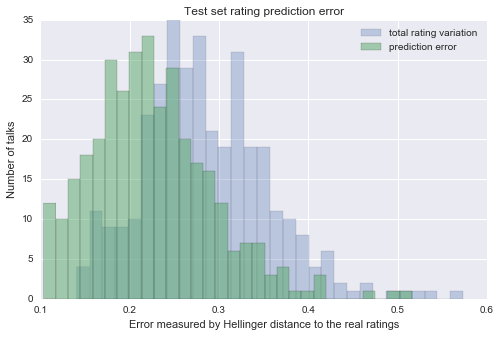

In [118]:
fig = plt.figure(figsize = (8,5))
ax = plt.gca()
avg_difference.hist(bins = 30,alpha = 0.3, label = 'total rating variation',ax = ax)
difference.hist(bins = 30,alpha = 0.5, label = 'prediction error', ax = ax)
ax.legend(loc = 'best',fontsize = 'medium')
plt.xlabel('Error measured by Hellinger distance to the real ratings')
plt.ylabel('Number of talks')
plt.title('Test set rating prediction error')

## Summary
The test set error is ~0.23, consistent with Cross-validation error got from the the training set. For comparison, two baseline estimations are made, the first is through random selection of 10 training talks and average their ratings (0.356), the second is to use the overall mean of the training set rating (0.29).